# Bike sharing demand

Forecast use of a city bikeshare system

# Part 1 : Unsupervised approach 

This notebooks treats an unsupervised approach, using only :
- the 3 outputs, corresponding to the number of bikes :
    - rented by registered customer
    - rented by casual customer
    - sum of the 2 (total rented) 
- the boolean time-related inputs inputs corresponding to :
    - whether the day is a working day
    - or a holiday
- And the associate datetime column.

A first analysis shows that there is a seasonality within these data, and a time series modelisation could be a good idea (using its forecast). But the timeline is not complete, and when it is possible to interpolate small missing gaps, from the 20th day to the end of each month is missing. 


TODO : Complete here 
A global time series model shows that ... , but the prediction is better when splitting the wordkink day, holiday and week-end day. 


<a id ="menu"></a>

1. [Exploratory Analysis](#section1)
    1. [Output/outputs ? Comparision of contract type](#section1.1)
    2. [Timeline integrity and missing values](#section1.2)
        1. [Huge gaps](#section1.2.1)
        2. [Small gaps](#section1.2.2)
    3. [Time series structure](#section1.3)
        1. [Daily seasonality](#section1.3.1)
        2. [Global trends](#section1.3.2)
        3. [Split data : working and non-working days](#section1.3.3)
    
2. [Time Series modelling](#section2)
    1. [With the whole data](#section2.1)
    2. [Only working days](#section2.2)
    3. [Only week-end](#section2.3)
    
    
    
<!--         1. [Classical preprocess](#section2.3.1)
        2. [Reduction of dimension](#section2.3.2)
        3. [Hand made](#section2.3.3)
        
3. [Classification](#section3)
    1. [Calling preprocesses, get datasets](#section3.1)
    2. [Different models](#section3.2)
          1. [Classification multi-class](#section3.2.1)
          2. [Classification model](#section3.2.2)
          3. [Set classification model parameters with CV](#section3.2.3)       
    3. [Analyse of the bests models](#section3.3)
          1. [Time of training and prediction](#section3.3.1)
          2. [Confusion Matrix](#section3.3.2)
4. [Putting the model into production](#section4)
    1. [Compute preprocess on data](#section4.1)
          1. [Export from beginning](#section4.1.1)
          2. [Complete preprocessing](#section4.1.2)
    2. [Support Vector Machine Classification](#section4.2) -->

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

DATA_PATH = "/home/clairegayral/Documents/kaggle/bikes/data/"
RES_PATH = "/home/clairegayral/Documents/kaggle/bikes/res/"


In [2]:
train = pd.read_csv(DATA_PATH+"train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1



<a id ="section1"></a>
<a id ="section1.1"></a>
[back to menu](#menu)

# 1. Exploratory Analysis
## 1.A. Output/outputs ?

My first idea is to predict 2 numbers and sum up :
nb_total = nb_casual + nb_registered 
or at least see if the distinction is important. 

But first of all, let's explore the different variables without any apriori.

In [3]:
df_output = train.loc[:,["casual","registered","count"]]
df_output.describe()

,casual,registered,count
count,10886.000000,10886.000000,10886.000000
mean,36.021955,155.552177,191.574132
std,49.960477,151.039033,181.144454
min,0.000000,0.000000,1.000000
25%,4.000000,36.000000,42.000000
50%,17.000000,118.000000,145.000000
75%,49.000000,222.000000,284.000000
max,367.000000,886.000000,977.000000


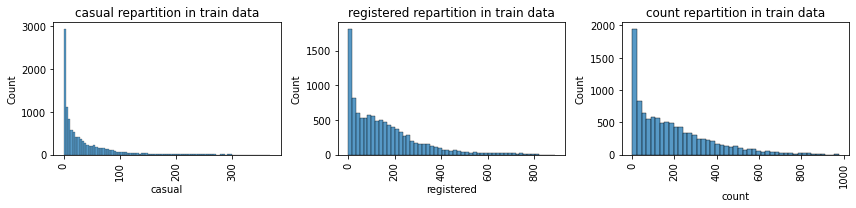

In [4]:
plt.figure(figsize=(12,3))
plot_iter = 1
for k in df_output.columns :
    plt.subplot(1,3,plot_iter)
    y = df_output.loc[:,k]
    sns.histplot(y)
    plt.title(k + " repartition in train data")
    plt.xticks(rotation=90)
    plot_iter += 1
plt.tight_layout()

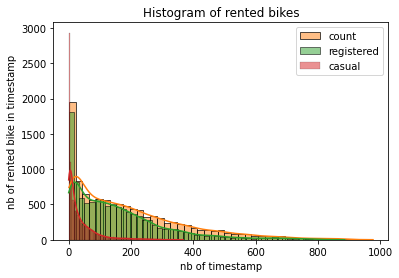

In [5]:
colors = sns.color_palette('tab10')
i=0
for k in ["count","registered", "casual"]:
    i+=1
    sns.histplot(data=df_output, x=k,  kde=True, label=k,color=colors[i])
    plt.legend()
plt.xlabel("nb of timestamp")
plt.ylabel("nb of rented bike in timestamp")
plt.title("Histogram of rented bikes")
plt.show()

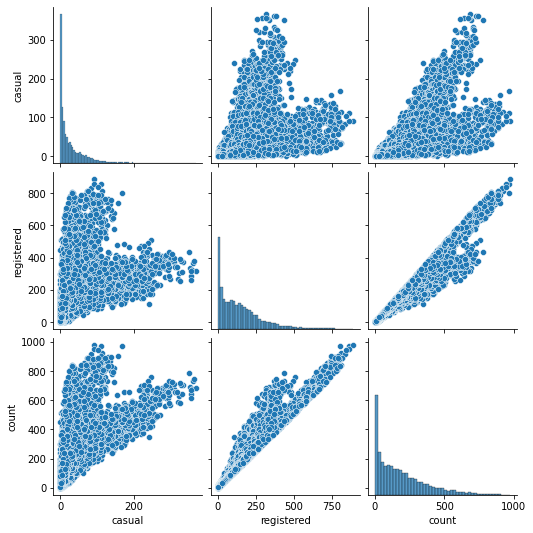

In [6]:
sns.pairplot(df_output)
# plt.title("Pair plot of the counts")

Subscriber rentals account for much of the rental trend, as there is almost a straight line between count and registered.

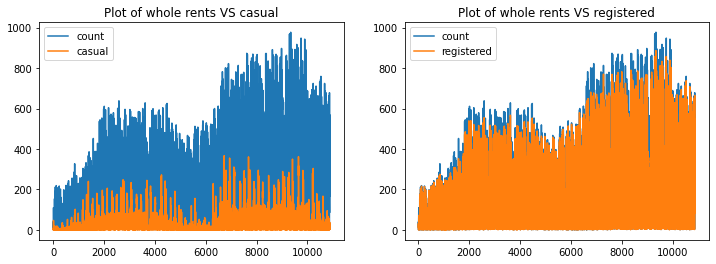

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(df_output["count"], label = "count")
plt.plot(df_output["casual"], label = "casual")
plt.legend()
plt.title("Plot of whole rents VS casual")

plt.subplot(1,2,2)
plt.plot(df_output["count"], label = "count")
plt.plot(df_output["registered"], label = "registered")
plt.legend()
plt.title("Plot of whole rents VS registered")

plt.show()

It seems that there is a real seasonality in these data. 

Text(0.5, 1.0, 'Plot of some rents VS casual')

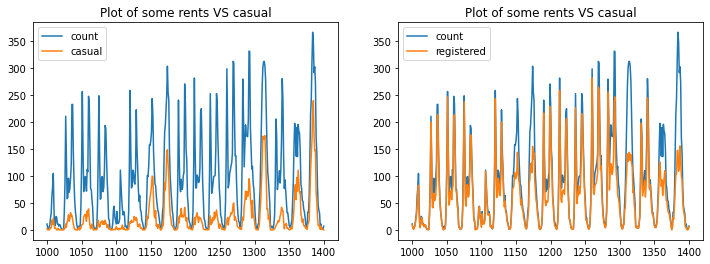

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(df_output.loc[1000:1400,"count"], label = "count")
plt.plot(df_output.loc[1000:1400,"casual"], label = "casual")
plt.legend()
plt.title("Plot of some rents VS casual")


plt.subplot(1,2,2)
plt.plot(df_output.loc[1000:1400,"count"], label = "count")
plt.plot(df_output.loc[1000:1400,"registered"], label = "registered")
plt.legend()
plt.title("Plot of some rents VS casual")



In [9]:
# transformed_output = pd.DataFrame()


def extend_one_row(train, idx):
    ## copy the row "count" types, and add the column "contract" taking values "casual" or "registered"
    tmp = train.loc[[idx],:].copy()
    n_casual = tmp["casual"].values[0]
    n_count = tmp["count"].values[0]
    tmp.loc[:,"contract"] = "registered"
    tmp = pd.concat([tmp]*n_count, ignore_index=True) # Ignores the index
    tmp.loc[:n_casual,"contract"]="casual"
    return tmp

## lop on whole index and concatenate 
# extended_data = pd.DataFrame()
# for idx in df_output.index[2000:3000] :
#     tmp = extend_one_row(train, idx)
#     extended_data = pd.concat((extended_data, tmp), axis=0)
# extended_data = extended_data.drop(["casual","registered","count"], axis=1)
# extended_data.to_csv(RES_PATH+"extended_train.csv")
extended_data = pd.read_csv(RES_PATH+"extended_train.csv", index_col=0)
extended_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,contract
0,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual
1,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual
2,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual
3,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual
4,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual


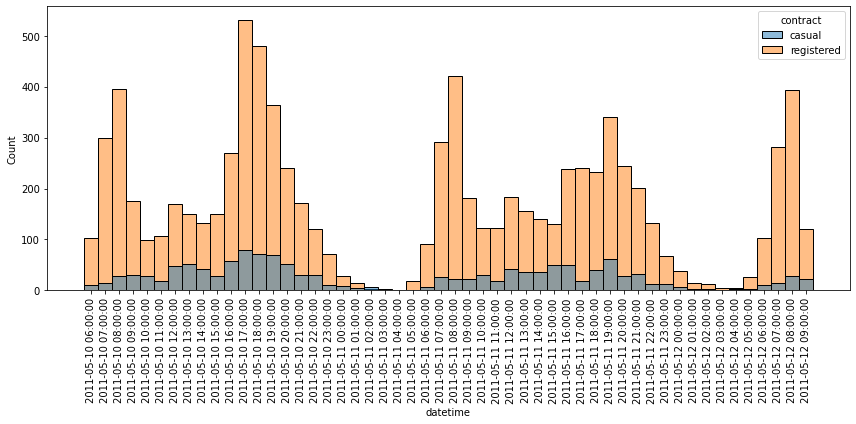

In [10]:
plt.figure(figsize=(12,6))
sns.histplot(data = extended_data.iloc[:10000], x="datetime", hue="contract")
plt.xticks(rotation=90)
plt.tight_layout()

<a id ="section1.2"></a>
<a id ="section1.2.1"></a>
[back to menu](#menu)

## 1.B. Timeline integrity and missing values
### 1.B.a Huge gaps (whole day missing)

In [11]:
## convert time :
d = train.datetime
d = pd.to_datetime(d, yearfirst=True)
train.loc[:,"datetime"] = d

In [12]:
ts_registered = pd.Series(data=train.loc[:,"registered"].values, index=train.loc[:,"datetime"], name = "registered")
ts_casual = pd.Series(data=train.loc[:,"casual"].values, index=train.loc[:,"datetime"], name = "casual")
ts_count = pd.Series(data=train.loc[:,"count"].values, index=train.loc[:,"datetime"], name = "count")
## the 3 counts in the same df :
df_ts = train.loc[:,["datetime","registered","casual", "count"]]
df_ts = df_ts.set_index("datetime")

#### Timespace first analysis

The frequency seems to be every hour, but it seems that every hour are not present ! 

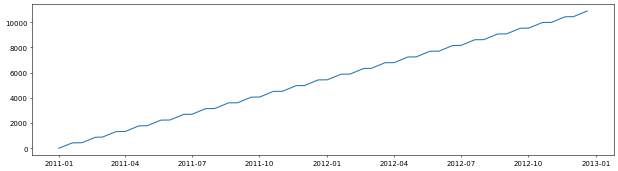

In [13]:
plt.figure(figsize=(15,4), dpi=50)
plt.plot(train.datetime , range(train.shape[0]))

## check if the timeline is complete : 
complete_timeline = pd.date_range(start = '2011-01-01 00:00:00', end = '2012-12-19 23:00:00' , freq="H")
missed_datetime = complete_timeline.difference(d.values)
# missed_datetime

In [14]:
print("complete timeline length = ", len(complete_timeline))
print("our timeline length = ", train.shape[0])

complete timeline length =  17256
our timeline length =  10886


Interpolation may not be such a good idea, knowing that 1/3 of data are missing.. Let's explore the timeline to be sure of what we are dealing with (missing day or only some hours ?)

In [15]:
missed_datetime = complete_timeline.difference(d.values)
missed_datetime = pd.to_datetime(missed_datetime.values, yearfirst=True)
missed_datetime = pd.DataFrame(index= missed_datetime)
missed_datetime.loc[:,'month'] = [d.month_name() for d in missed_datetime.index]
missed_datetime.loc[:,'day'] = [d.day_name() for d in missed_datetime.index]
missed_datetime.loc[:,'hour'] = [d.hour for d in missed_datetime.index]
missed_datetime.loc[:,'date'] = [d.date() for d in missed_datetime.index]
missed_datetime = missed_datetime.reset_index()
missed_datetime.head(3)

,index,month,day,hour,date
0,2011-01-02 05:00:00,January,Sunday,5,2011-01-02
1,2011-01-03 02:00:00,January,Monday,2,2011-01-03
2,2011-01-03 03:00:00,January,Monday,3,2011-01-03


In [16]:
missed_datetime.date.value_counts().value_counts()

24    263
1      36
2       5
12      1
Name: date, dtype: int64

Grouped by date, it seems that most of missing data correspond to whole day missing (263 hours), and some are juste missed hour(36 correspon to 1 hour missed in one day, and 5 are 2 hours)

In [17]:
tmp = train[["datetime", "count"]].copy()
tmp = tmp.set_index("datetime")
tmp.loc[:,'month'] = [d.month_name() for d in tmp.index]
tmp.loc[:,'day'] = [d.day_name() for d in tmp.index]
tmp.loc[:,'hour'] = [d.hour for d in tmp.index]
tmp.loc[:,'date'] = [d.date() for d in tmp.index]
tmp.date.value_counts().value_counts()

24    414
23     36
22      5
12      1
Name: date, dtype: int64

A contrario, there are 414 days with the 24h mesures, and we find back the ponctual missing measures (36 days with 1 missing value, 5 with 2 and one with 12h missing)

#### Repartition of missing days :

In [18]:
missing_day = pd.unique(missed_datetime.date)[(missed_datetime.date.value_counts() == 24).sort_index()]
missing_day = pd.DataFrame(index=pd.to_datetime(missing_day))
missing_day.loc[:,"value"] = 1
missing_day.loc[:,'year'] = [d.year for d in missing_day.index]
missing_day.loc[:,'month'] = [d.month_name() for d in missing_day.index]
missing_day.loc[:,'day'] = [d.day_name() for d in missing_day.index]

In [19]:
missing_day[["value","year"]].groupby("year").count()

,value
year,
2011,137
2012,126


In [20]:
months_categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
print("2011 :")
tmp = missing_day[missing_day.year==2011]
tmp[["value","month"]].groupby("month").count().transpose()

2011 :


month,April,August,December,February,January,July,June,March,May,November,October,September
value,11,12,12,9,12,12,11,12,12,11,12,11


In [21]:
print("2012 :")
tmp = missing_day[missing_day.year==2012]
tmp[["value","month"]].groupby("month").count().transpose()


2012 :


month,April,August,February,January,July,June,March,May,November,October,September
value,11,12,10,12,12,11,12,12,11,12,11


So, the missing days seem to be homogeneously distributed ... To use time series modelling:
* I am to interpolate the small holes
* I'll trick for the whole day missing, by remove them from the calendar (be caution with that -> if the data to predict are not that sparse)

Are the missing days consecutive ? 

In [22]:
for year in [2011,2012]:
    sub = missing_day[missing_day.year == year]
    for month in months_categories :
        tmp = sub[sub.month == month].index.day.values
        print(year, month)
        print(tmp)

2011 January
[20 21 22 23 24 25 26 27 28 29 30 31]
2011 February
[20 21 22 23 24 25 26 27 28]
2011 March
[20 21 22 23 24 25 26 27 28 29 30 31]
2011 April
[20 21 22 23 24 25 26 27 28 29 30]
2011 May
[20 21 22 23 24 25 26 27 28 29 30 31]
2011 June
[20 21 22 23 24 25 26 27 28 29 30]
2011 July
[20 21 22 23 24 25 26 27 28 29 30 31]
2011 August
[20 21 22 23 24 25 26 27 28 29 30 31]
2011 September
[20 21 22 23 24 25 26 27 28 29 30]
2011 October
[20 21 22 23 24 25 26 27 28 29 30 31]
2011 November
[20 21 22 23 24 25 26 27 28 29 30]
2011 December
[20 21 22 23 24 25 26 27 28 29 30 31]
2012 January
[20 21 22 23 24 25 26 27 28 29 30 31]
2012 February
[20 21 22 23 24 25 26 27 28 29]
2012 March
[20 21 22 23 24 25 26 27 28 29 30 31]
2012 April
[20 21 22 23 24 25 26 27 28 29 30]
2012 May
[20 21 22 23 24 25 26 27 28 29 30 31]
2012 June
[20 21 22 23 24 25 26 27 28 29 30]
2012 July
[20 21 22 23 24 25 26 27 28 29 30 31]
2012 August
[20 21 22 23 24 25 26 27 28 29 30 31]
2012 September
[20 21 22 23 24 25 26 

It is often the end of the month that is missing. It would have been easier if the missing days were less gathered. 

<a id ="section1.2.2"></a>
[back to menu](#menu)

### 1.B.b Small gaps

#### Resampling to have a regular timegap 

So let's tackle the small gaps ! Let's upsample and interpolate them as in [this article](https://towardsdatascience.com/pandas-resample-tricks-you-should-know-for-manipulating-time-series-data-7e9643a7e7f3), while dropping the all day missing datetime.

To get the small missing values, let's use the [pandas upsampling documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) :

In [23]:
df_ts_complete = df_ts.resample("H").asfreq()

## get missing timestamps to extract whole missing day datatime
tmp = df_ts_complete[df_ts_complete.registered.isna()].index
tmp = pd.DataFrame(index=tmp)
tmp.loc[:,'date'] = [d.date() for d in tmp.index]
missing_day = pd.unique(tmp.date)[(tmp.date.value_counts() >10).sort_index()]
missing_day_index = tmp[tmp.date.isin(missing_day)].index

## drop missing days in df_ts_complete :
df_ts_work = df_ts_complete.drop(missing_day_index)

## interpolate ponctual missing hours
df_ts_work = df_ts_work.interpolate()

## Checkpoint : save the result : 
df_ts_work.to_csv(RES_PATH+"ts_dataframe_sampling.csv")
df_ts.shape, df_ts_work.shape

((10886, 3), (10932, 3))

In [24]:
ts_registered = df_ts_work.registered
ts_casual = df_ts_work.casual
ts_count = df_ts_work.loc[:,'count']

I keep the corresponding time series (so there are missing values every end of the month).

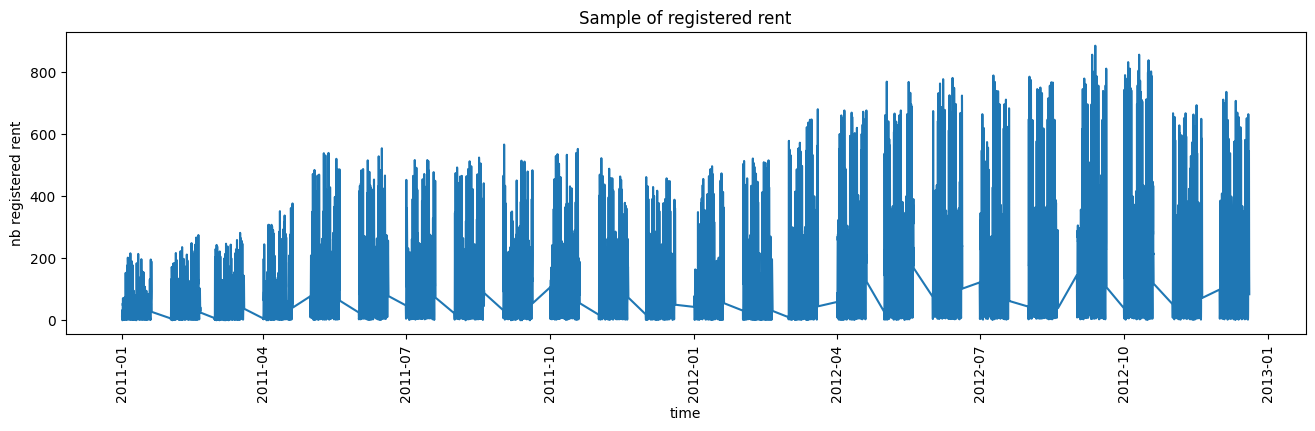

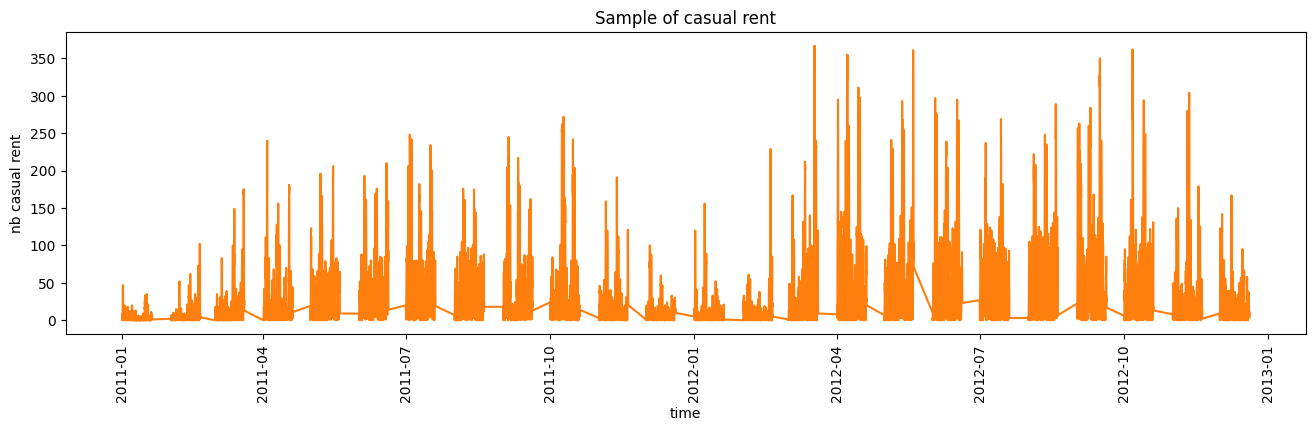

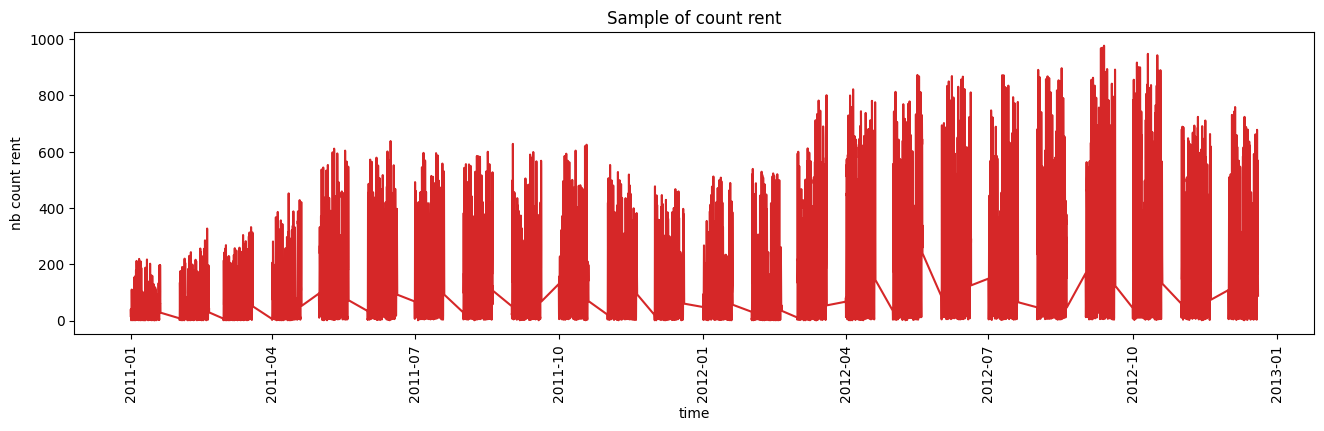

In [25]:
# Draw ts plot
plt.figure(figsize=(16,4), dpi=100)
plt.plot(ts_registered.index, ts_registered.values, color='tab:blue')
plt.gca().set(title="Sample of registered rent", xlabel="time", ylabel="nb registered rent")
plt.xticks(rotation=90, fontsize=10)
plt.show()

# Draw ts plot
plt.figure(figsize=(16,4), dpi=100)
plt.plot(ts_casual.index, ts_casual.values, color='tab:orange')
plt.gca().set(title="Sample of casual rent", xlabel="time", ylabel="nb casual rent")
plt.xticks(rotation=90, fontsize=10)
plt.show()

# Draw ts plot
plt.figure(figsize=(16,4), dpi=100)
plt.plot(ts_count.index, ts_count.values, color='tab:red')
plt.gca().set(title="Sample of count rent", xlabel="time", ylabel="nb count rent")
plt.xticks(rotation=90, fontsize=10)
plt.show()

As I do not want these gaps to be an issue, let's drop the time index to replace it with a range one :

In [26]:
registered = df_ts_work.registered.values
casual = df_ts_work.casual.values
count = df_ts_work.loc[:,'count'].values

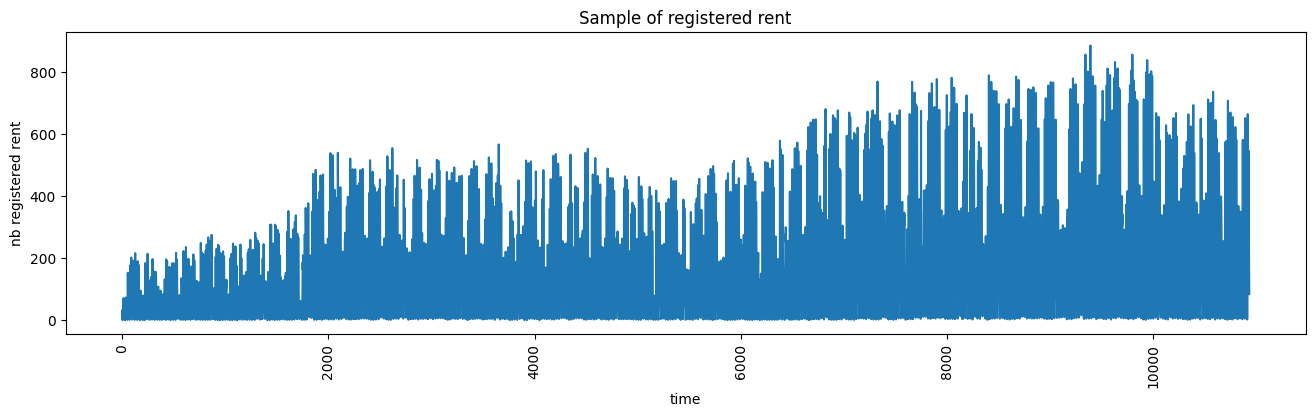

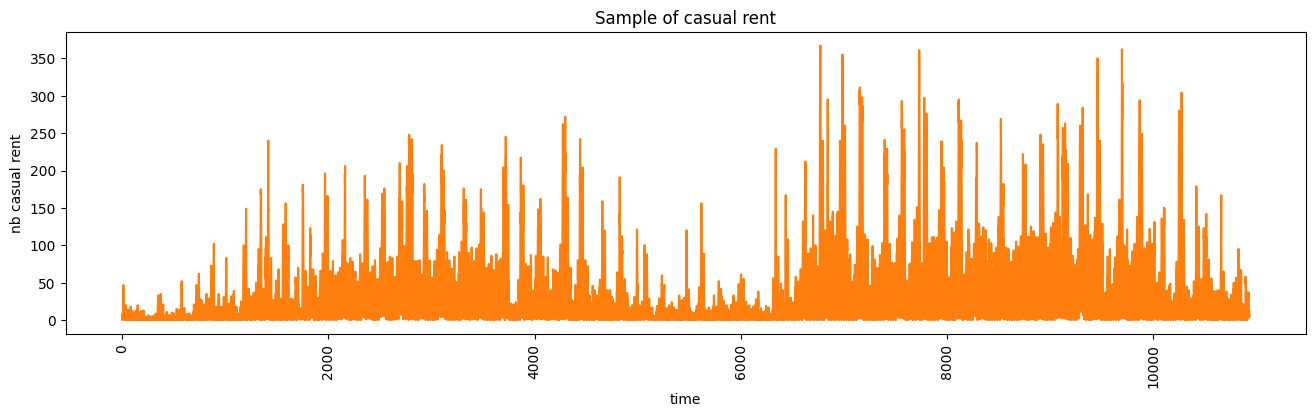

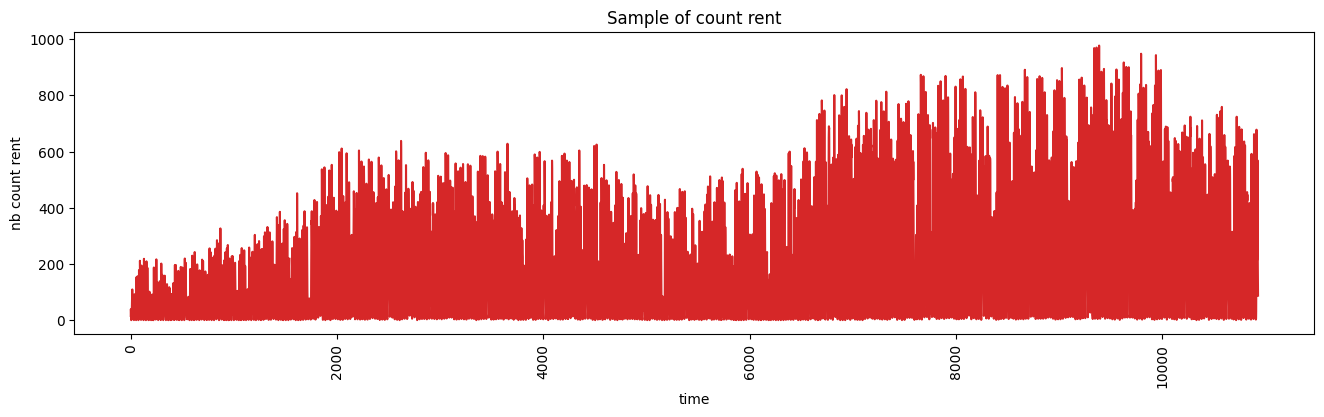

In [27]:
# Draw ts plot
plt.figure(figsize=(16,4), dpi=100)
plt.plot(registered, color='tab:blue')
plt.gca().set(title="Sample of registered rent", xlabel="time", ylabel="nb registered rent")
plt.xticks(rotation=90, fontsize=10)
plt.show()

# Draw ts plot
plt.figure(figsize=(16,4), dpi=100)
plt.plot(casual, color='tab:orange')
plt.gca().set(title="Sample of casual rent", xlabel="time", ylabel="nb casual rent")
plt.xticks(rotation=90, fontsize=10)
plt.show()

# Draw ts plot
plt.figure(figsize=(16,4), dpi=100)
plt.plot(count, color='tab:red')
plt.gca().set(title="Sample of count rent", xlabel="time", ylabel="nb count rent")
plt.xticks(rotation=90, fontsize=10)
plt.show()


<a id ="section1.3"></a>
<a id ="section1.3.1"></a>
[back to menu](#menu)

## 1.C Time series structure
### 1.C.a. Daily seasonality

Now that the sampling is clearer, let's focus on the seasonality : 

In [28]:
# ts = ts_registered.copy().rename({"registered":"value"})
# contrat = "Registered" ## type of count
# df = ts.reset_index().rename(columns={"registered":"value"})
df_ts = pd.read_csv(RES_PATH+"ts_dataframe_sampling.csv", index_col=0)
df_ts.index = pd.to_datetime(df_ts.index)

# # Prepare data
df_ts.loc[:,'year'] = [d.year for d in df_ts.index]
df_ts.loc[:,'month'] = [d.month_name() for d in df_ts.index]
df_ts.loc[:,'day'] = [d.day_name() for d in df_ts.index]
df_ts.loc[:,'hour'] = [d.hour for d in df_ts.index]
df_ts

,registered,casual,count,year,month,day,hour
datetime,,,,,,,
2011-01-01 00:00:00,13.0,3.0,16.0,2011,January,Saturday,0
2011-01-01 01:00:00,32.0,8.0,40.0,2011,January,Saturday,1
2011-01-01 02:00:00,27.0,5.0,32.0,2011,January,Saturday,2
2011-01-01 03:00:00,10.0,3.0,13.0,2011,January,Saturday,3
2011-01-01 04:00:00,1.0,0.0,1.0,2011,January,Saturday,4
...,...,...,...,...,...,...,...
2012-12-19 19:00:00,329.0,7.0,336.0,2012,December,Wednesday,19
2012-12-19 20:00:00,231.0,10.0,241.0,2012,December,Wednesday,20
2012-12-19 21:00:00,164.0,4.0,168.0,2012,December,Wednesday,21


Let's see the daily seasonality :

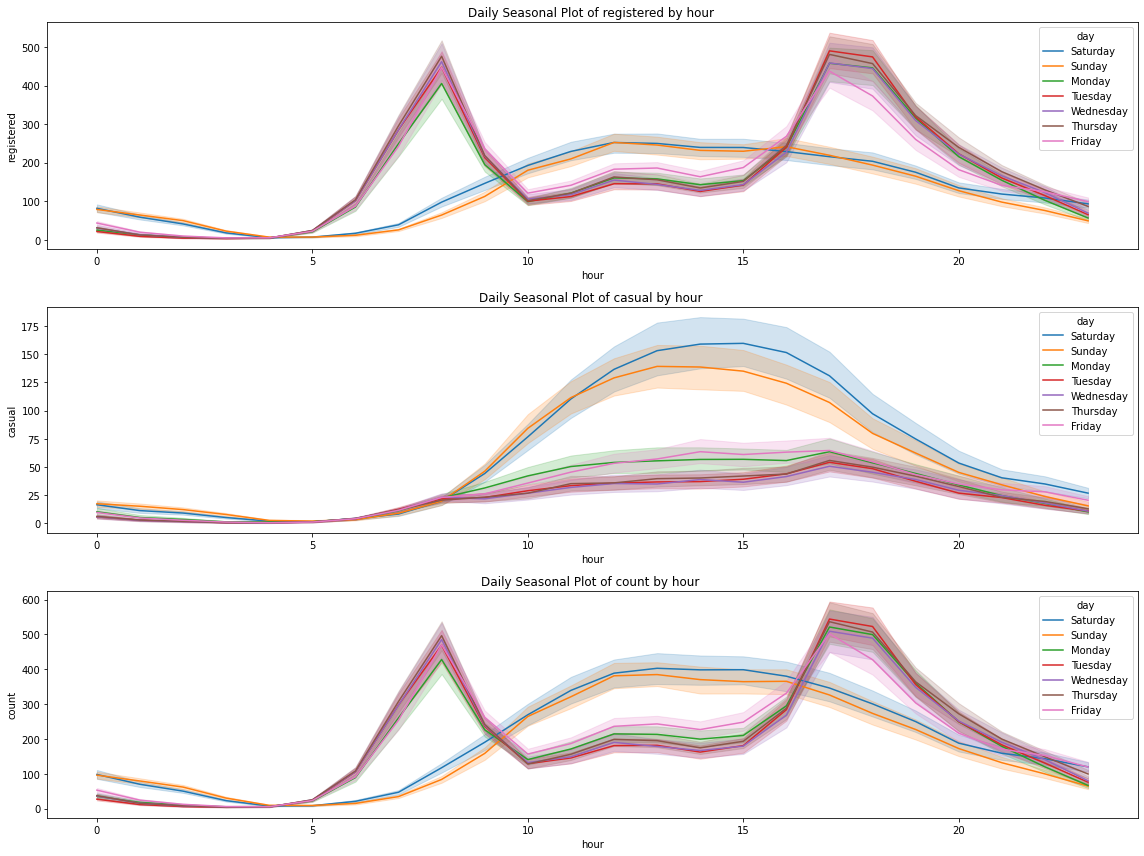

In [29]:
plt.figure(figsize=(16,12))#, dpi= 80)
plt.subplot(3,1,1)
contract = "registered"
sns.lineplot(x="hour", y=contract, hue="day", data=df_ts)
plt.title("Daily Seasonal Plot of "+ contract +" by hour ", fontsize=12)

plt.subplot(3,1,2)
contract = "casual"
sns.lineplot(x="hour", y=contract, hue="day", data=df_ts)
plt.title("Daily Seasonal Plot of "+ contract +" by hour ", fontsize=12)

plt.subplot(3,1,3)
contract = "count"
sns.lineplot(x="hour", y=contract, hue="day", data=df_ts)
plt.title("Daily Seasonal Plot of "+ contract +" by hour ", fontsize=12)

plt.tight_layout()
plt.show()

Clearly, the Saturday and Sunday rents are really different from other days ! I think to have a better performance, it is a good idea to treat the weed-end days as another modelisation. 

Is there such a difference between hollidays and working days ? I add the corresponding collumn from train and I interpolate corresponding to the upsampling. Here, as it is important to keep boolean values, the interpolation is "nearest". 

In [53]:
ts_daytype = train.loc[:,["datetime","holiday","workingday"]]
ts_daytype = ts_daytype.set_index("datetime")
## upsampling droping whole missing days : 
df2 = pd.merge(df_ts, ts_daytype, on="datetime", how="left")
df2 = df2.interpolate("nearest")

## add week-end information : 
df2.loc[:,"weekend"] = 0
df2.loc[df2.day.isin(["Saturday", "Sunday"]),"weekend"] = 1
## check the separation of days : 
df2[["workingday","holiday", "weekend"]].sum(axis=1).value_counts()

1.0    10932
dtype: int64

Good news ! The 3 groups are well-separated, thus it is possible to gather them in one column "daytype" :

In [54]:
df2.loc[df2.holiday == 1, "daytype"] = "holiday"
df2.loc[df2.workingday == 1, "daytype"] = "workingday"
df2.loc[df2.weekend == 1, "daytype"] = "weekend"
# df2 = df2.drop(columns=["holiday", "workingday", "weekend"])

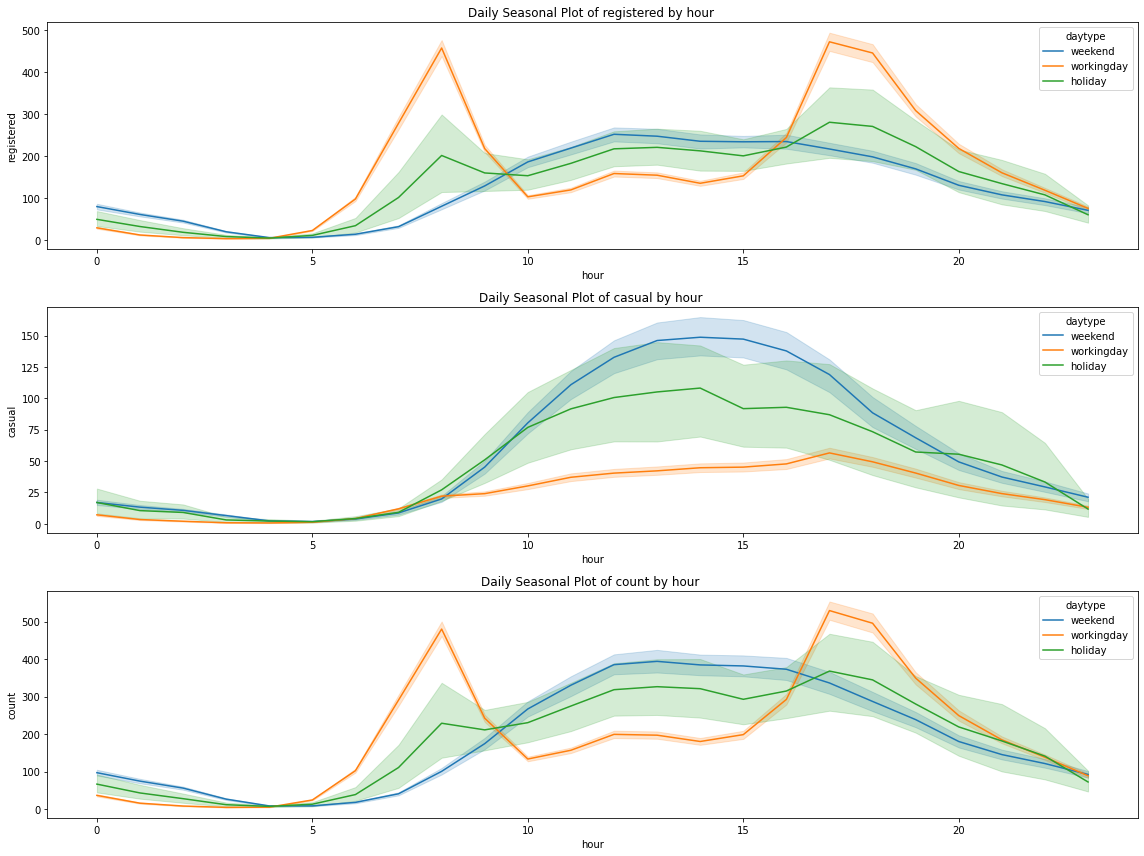

In [55]:
plt.figure(figsize=(16,12))#, dpi= 80)
plt.subplot(3,1,1)
contract = "registered"
sns.lineplot(x="hour", y=contract, hue="daytype", data=df2)
plt.title("Daily Seasonal Plot of "+ contract +" by hour ", fontsize=12)

plt.subplot(3,1,2)
contract = "casual"
sns.lineplot(x="hour", y=contract, hue="daytype", data=df2)
plt.title("Daily Seasonal Plot of "+ contract +" by hour ", fontsize=12)

plt.subplot(3,1,3)
contract = "count"
sns.lineplot(x="hour", y=contract, hue="daytype", data=df2)
plt.title("Daily Seasonal Plot of "+ contract +" by hour ", fontsize=12)

plt.tight_layout()
plt.show()

So, we find back that there is a seasonality in working days, and a different one in week-end. The holidays seem to be in the middle. 

It would need a bot more treatments to plot the median between holidays and non-holidays distribution. Checking quickly that is may be the mean of the two distributions (knowing that there are 2.5 times more day in the week than in the week-end) :

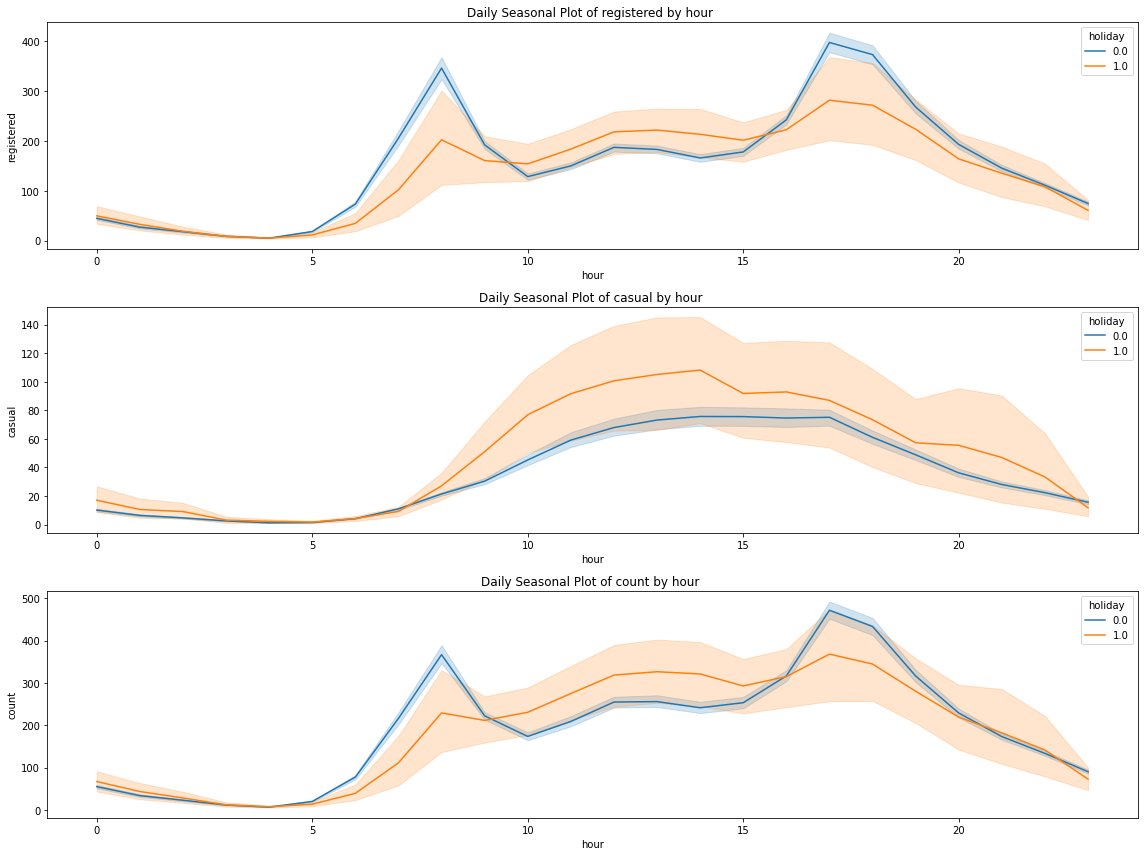

In [64]:
plt.figure(figsize=(16,12))#, dpi= 80)
plt.subplot(3,1,1)
contract = "registered"
sns.lineplot(x="hour", y=contract, hue="holiday", data=df2)
plt.title("Daily Seasonal Plot of "+ contract +" by hour ", fontsize=12)

plt.subplot(3,1,2)
contract = "casual"
sns.lineplot(x="hour", y=contract, hue="holiday", data=df2)
plt.title("Daily Seasonal Plot of "+ contract +" by hour ", fontsize=12)

plt.subplot(3,1,3)
contract = "count"
sns.lineplot(x="hour", y=contract, hue="holiday", data=df2)
plt.title("Daily Seasonal Plot of "+ contract +" by hour ", fontsize=12)

plt.tight_layout()
plt.show()


<a id ="section1.3.2"></a>
[back to menu](#menu)

### 1.C.b Global trends
    
To be sure that there is no other seasonality in the time serie, let's zoom out to the "month/day" scale.

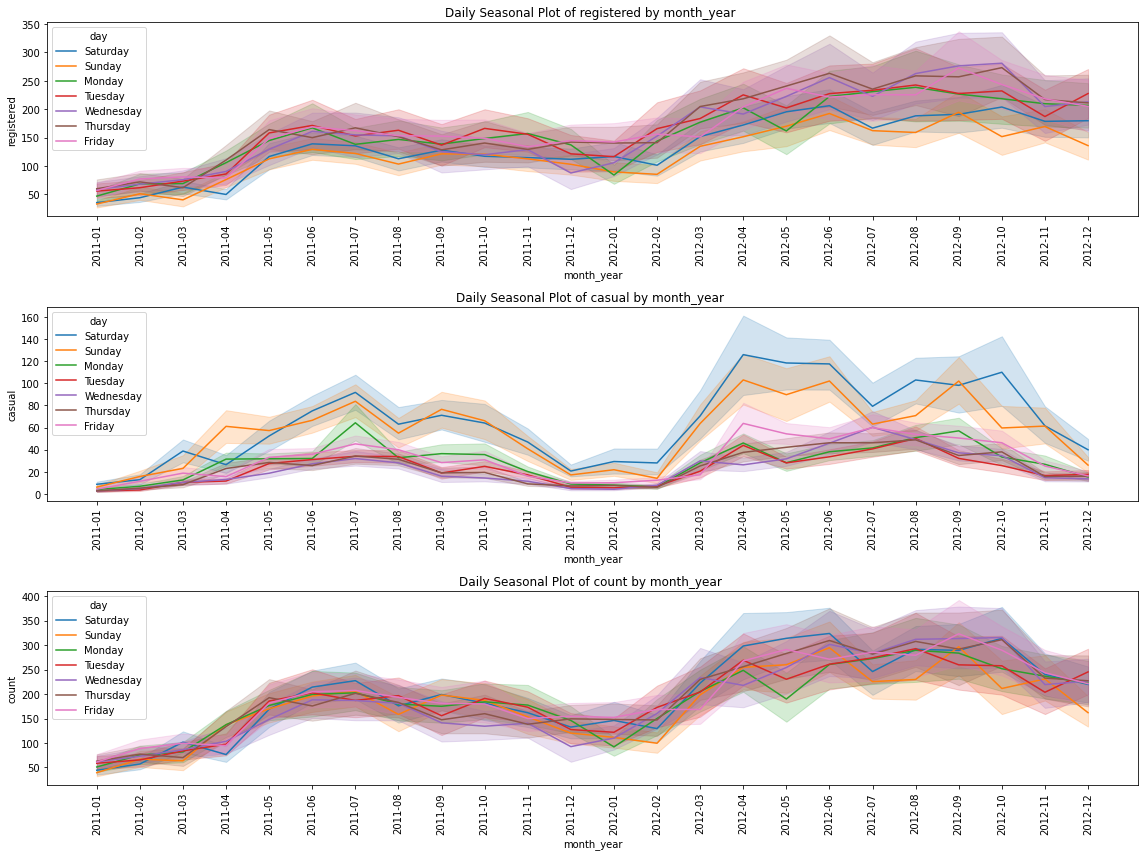

In [72]:
df_ts.loc[:,"month_year"] = df_ts.index.strftime('%Y-%m')

plt.figure(figsize=(16,12))#, dpi= 80)
plt.subplot(3,1,1)
contract = "registered"
sns.lineplot(x="month_year", y=contract, hue="day", data=df_ts)
plt.xticks(rotation=90)
plt.title("Daily Seasonal Plot of "+ contract +" by month_year ", fontsize=12)

plt.subplot(3,1,2)
contract = "casual"
sns.lineplot(x="month_year", y=contract, hue="day", data=df_ts)
plt.xticks(rotation=90)
plt.title("Daily Seasonal Plot of "+ contract +" by month_year ", fontsize=12)

plt.subplot(3,1,3)
contract = "count"
sns.lineplot(x="month_year", y=contract, hue="day", data=df_ts)
plt.xticks(rotation=90)
plt.title("Daily Seasonal Plot of "+ contract +" by month_year ", fontsize=12)

plt.tight_layout()
plt.show()

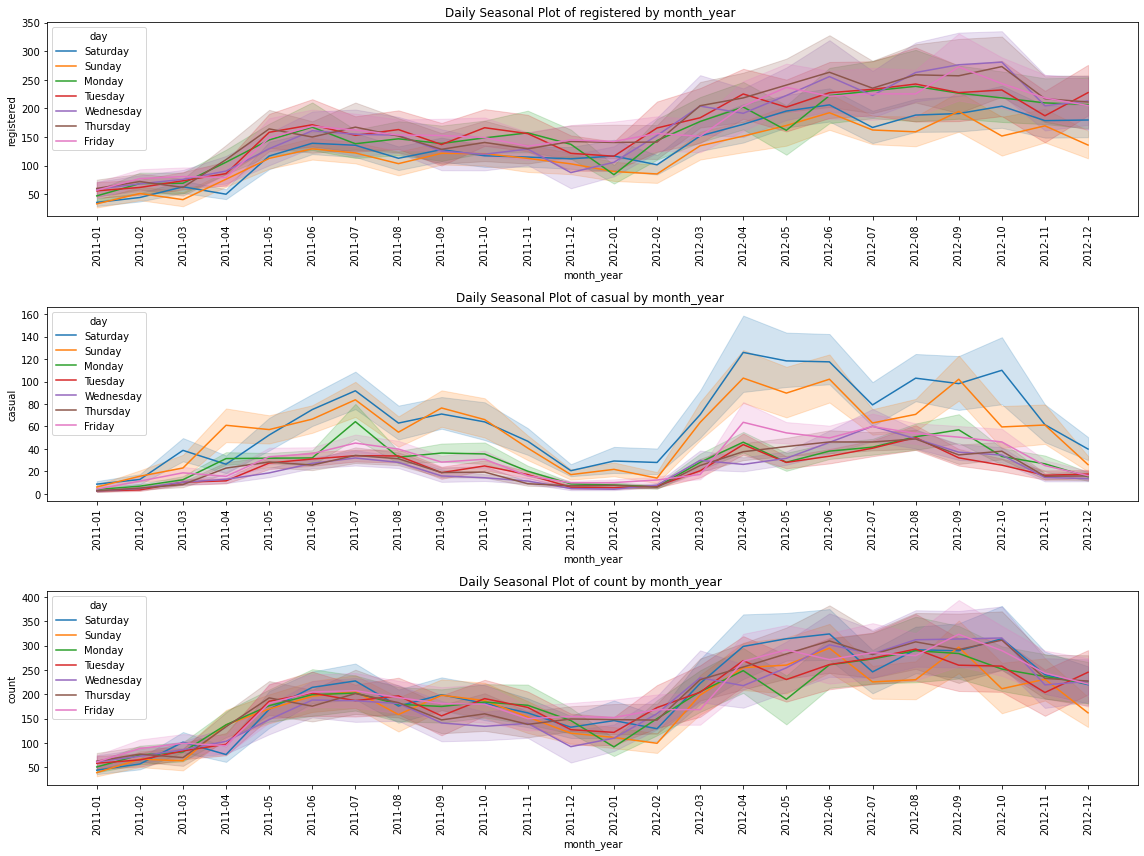

In [75]:
df_ts.loc[:,"month_year"] = df_ts.index.strftime('%Y-%m')

plt.figure(figsize=(16,12))#, dpi= 80)
plt.subplot(3,1,1)
contract = "registered"
sns.lineplot(x="month_year", y=contract, hue="day", data=df_ts)
plt.xticks(rotation=90)
plt.title("Daily Seasonal Plot of "+ contract +" by month_year ", fontsize=12)

plt.subplot(3,1,2)
contract = "casual"
sns.lineplot(x="month_year", y=contract, hue="day", data=df_ts)
plt.xticks(rotation=90)
plt.title("Daily Seasonal Plot of "+ contract +" by month_year ", fontsize=12)

plt.subplot(3,1,3)
contract = "count"
sns.lineplot(x="month_year", y=contract, hue="day", data=df_ts)
plt.xticks(rotation=90)
plt.title("Daily Seasonal Plot of "+ contract +" by month_year ", fontsize=12)

plt.tight_layout()
plt.show()

Last question : Is there a seasonality whitin days ? 

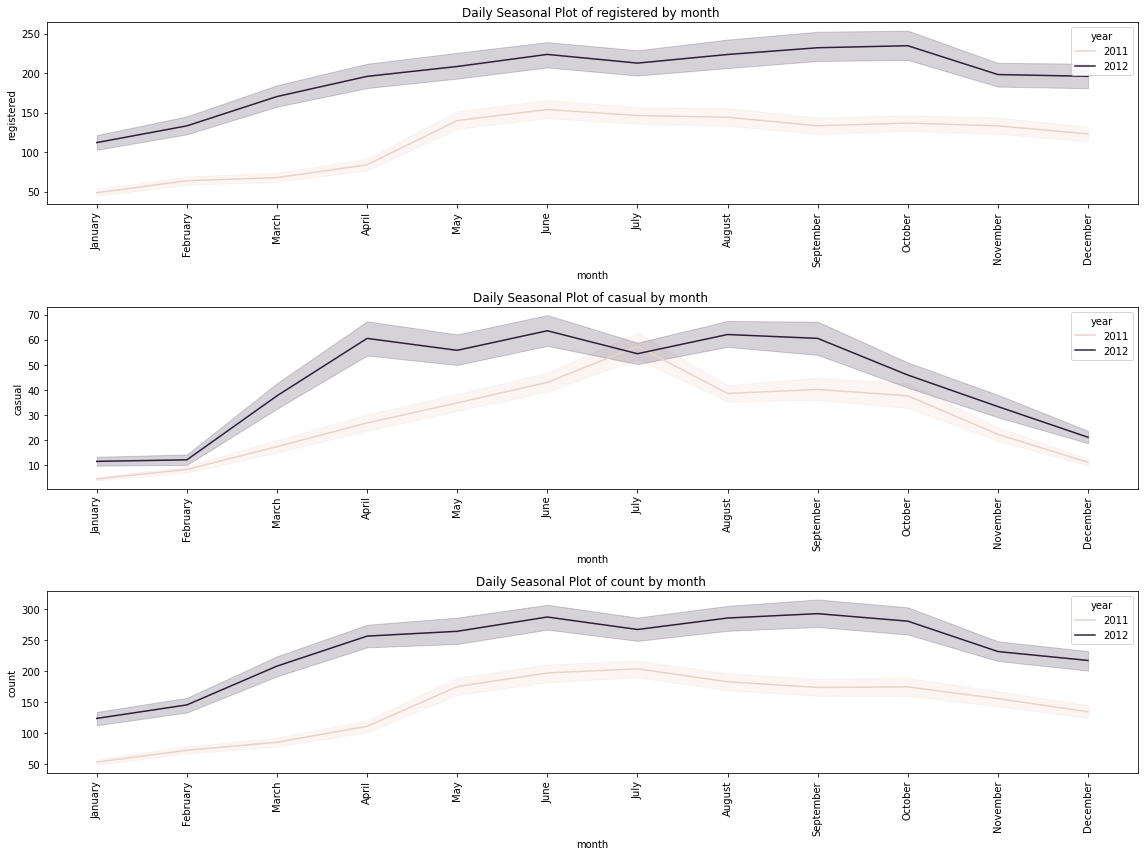

In [77]:
plt.figure(figsize=(16,12))#, dpi= 80)
plt.subplot(3,1,1)
contract = "registered"
sns.lineplot(x="month", y=contract, hue="year", data=df_ts)
plt.xticks(rotation=90)
plt.title("Daily Seasonal Plot of "+ contract +" by month ", fontsize=12)

plt.subplot(3,1,2)
contract = "casual"
sns.lineplot(x="month", y=contract, hue="year", data=df_ts)
plt.xticks(rotation=90)
plt.title("Daily Seasonal Plot of "+ contract +" by month ", fontsize=12)

plt.subplot(3,1,3)
contract = "count"
sns.lineplot(x="month", y=contract, hue="year", data=df_ts)
plt.xticks(rotation=90)
plt.title("Daily Seasonal Plot of "+ contract +" by month ", fontsize=12)

plt.tight_layout()
plt.show()

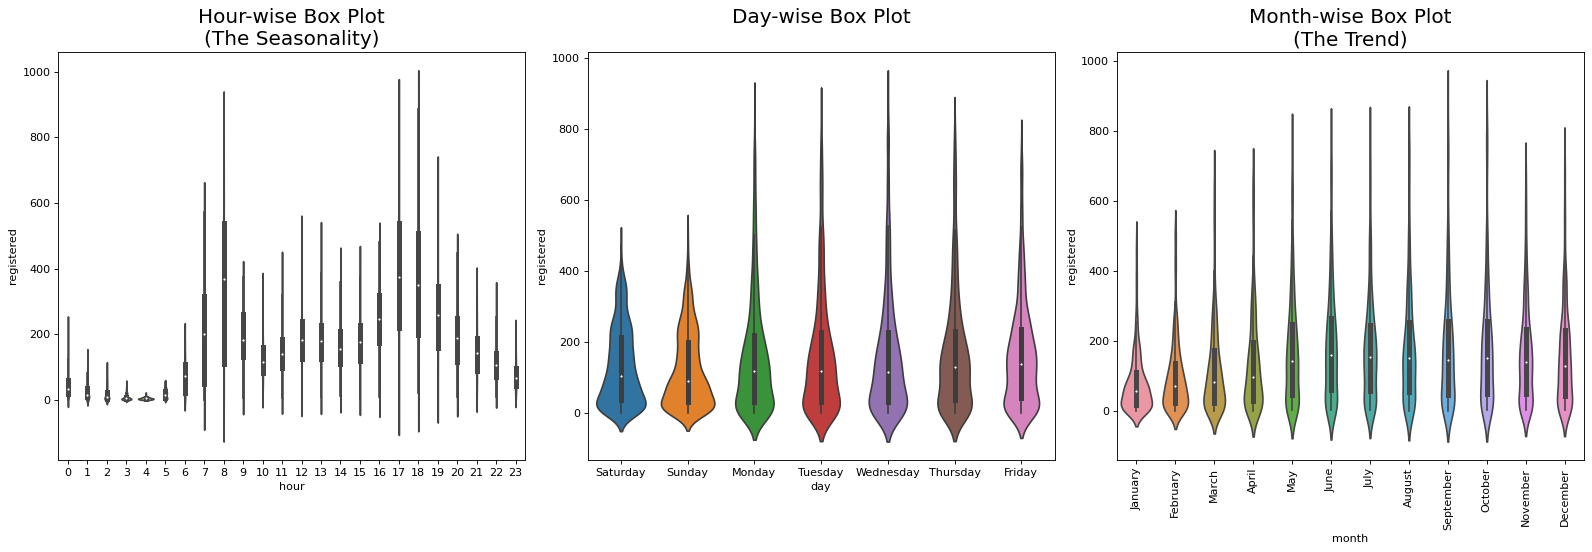

In [80]:
contract = "registered"

# Draw Plot
fig, axes = plt.subplots(1, 3, figsize=(20,7), dpi= 80)
sns.violinplot(x='hour', y=contract, data=df_ts, ax=axes[0])
sns.violinplot(x='day', y=contract, data=df_ts, ax=axes[1])
sns.violinplot(x='month', y=contract, data=df_ts, ax=axes[2])
plt.xticks(rotation=90)

# Set Title
axes[0].set_title('Hour-wise Box Plot\n(The Seasonality)', fontsize=18) 
axes[1].set_title('Day-wise Box Plot\n', fontsize=18)
axes[2].set_title('Month-wise Box Plot\n(The Trend)', fontsize=18)
plt.tight_layout()
plt.show()

<a id ="section1.3.3"></a>
[back to menu](#menu)

### 1.C.c Split data : working and non-working days


In [92]:
#TODO

<a id ="section2"></a>
<a id ="section2.1"></a>
[back to menu](#menu)

# 2. Time Series modelling :

## 2.A Global  :
#### Time Series Decomposition :
There are numerous tutorials that explains how to decompose the time series, such that :

* https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
* https://www.machinelearningplus.com/time-series/time-series-analysis-python/
* https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* a whole book : https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
* the pandas doc on ts : https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
* more math : https://otexts.com/fpp2/classical-decomposition.html

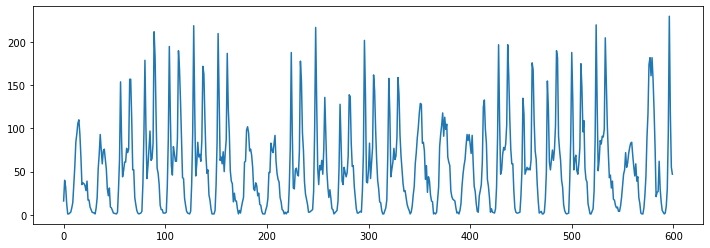

In [104]:
contract = "count"
ts = df_ts.loc[:,contract].copy()
plt.figure(figsize=(12,4))
plt.plot(ts.values[:600])
plt.show()

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

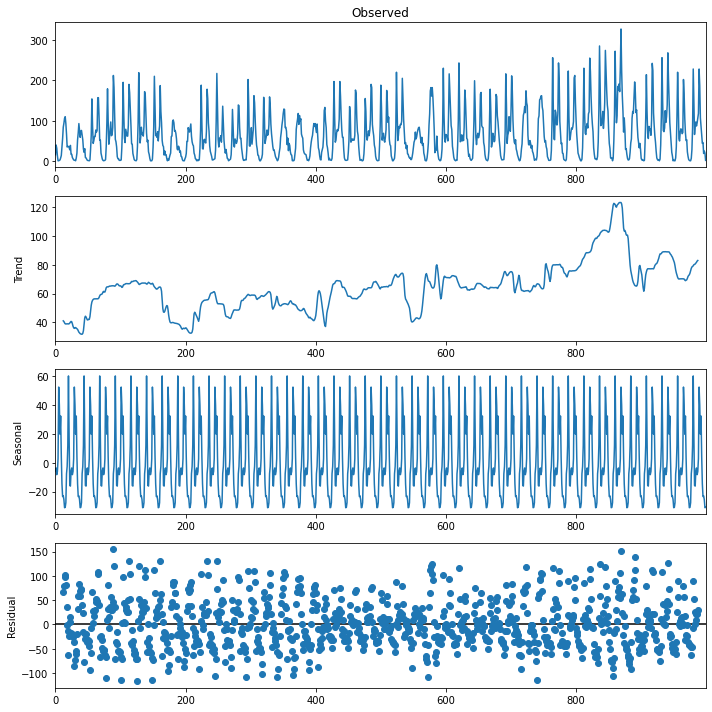

In [135]:
## additive modelling :
result_add = seasonal_decompose(ts.values[:1000], model="additive", period=24)
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

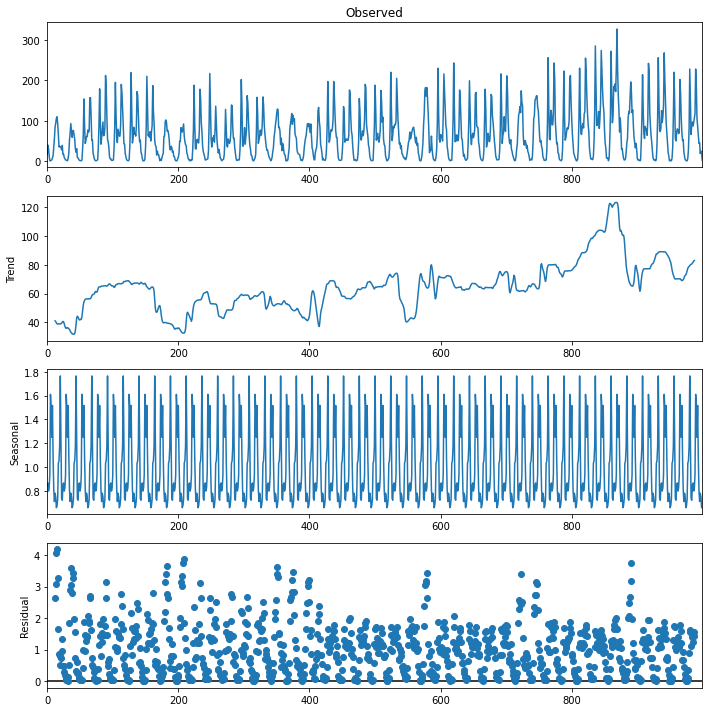

In [136]:
## multiplicative model 
result_mult = seasonal_decompose(ts.values[:1000], model="multiplicative", period=24)
plt.rcParams.update({'figure.figsize': (10,10)})
result_mult.plot()
plt.show()

A multiplicative model is much better (residual < 4). The trend does not seem that easy to decompose, and the error really seem to be linked to the weekend. 

#### Autocorrelation : 
Let's check the lags as in [this ressource](https://www.machinelearningplus.com/time-series/time-series-analysis-python/): 

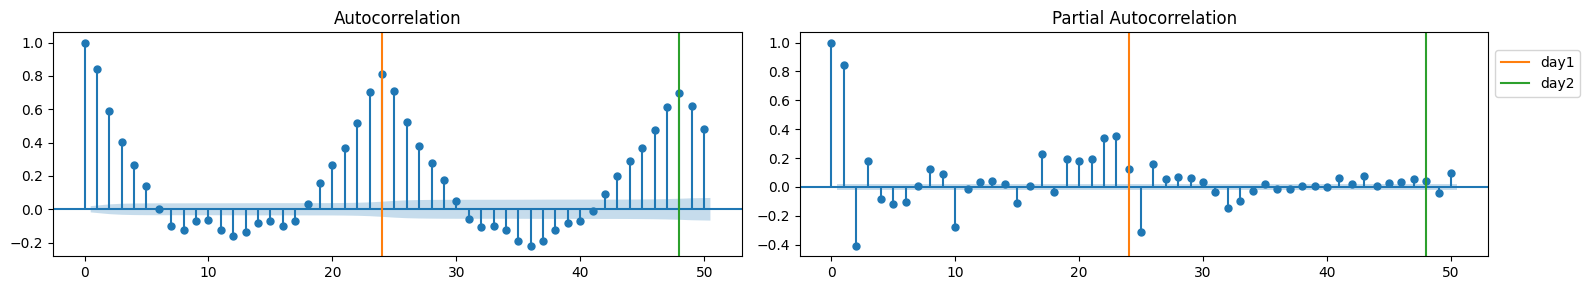

In [175]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = ts
nlags = 50

## Calculate ACF and PACF upto nlags lags
# acf_ = acf(df.values, nlags=nlags)
# pacf_ = pacf(df.values, nlags=nlags)
# print(acf_, pacf_)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.values.tolist(), lags=nlags, ax=axes[0])
plot_pacf(df.values.tolist(), lags=nlags, ax=axes[1])

colors = sns.color_palette("tab10")
for n in range(1,3):
    x = 24*n
    axes[0].axvline(x=x, label="day"+str(n), c=colors[n])
    axes[1].axvline(x=x, label="day"+str(n), c=colors[n])

axes[1].legend(bbox_to_anchor=(1, 0.95))
plt.tight_layout()

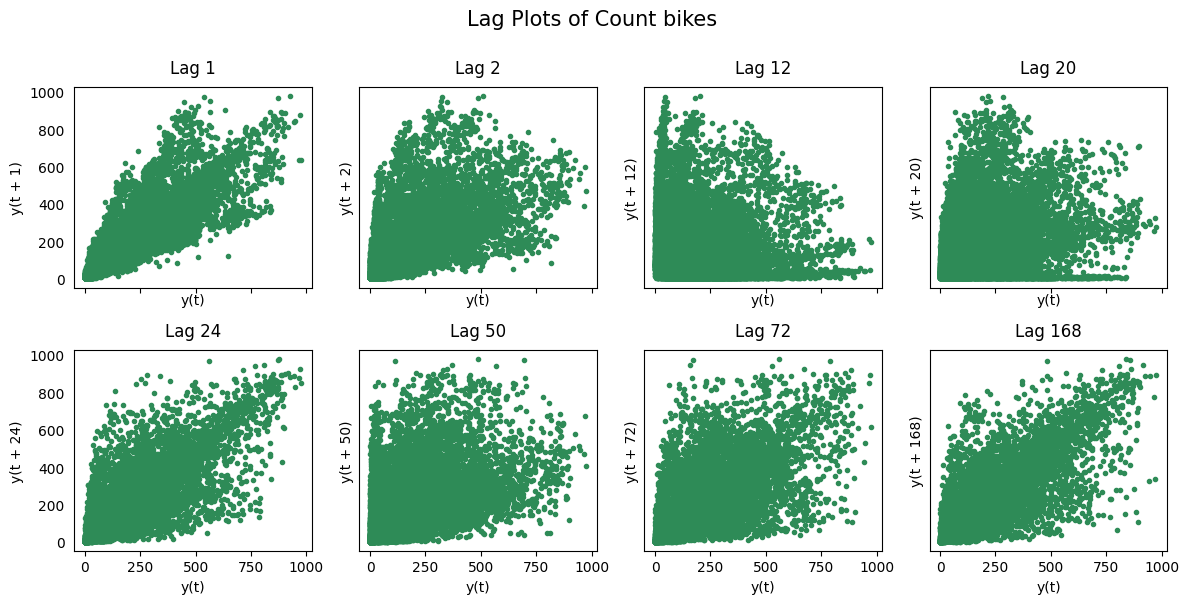

In [196]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True, dpi=100)
list_lags = [1,2,12,20,24,50,72,168]
for i, ax in enumerate(axes.flatten()[:8]):
    nlag = list_lags[i]
    lag_plot(ts, lag=nlag, ax=ax, c='seagreen', marker='.')
    ax.set_title('Lag ' + str(nlag))

fig.suptitle('Lag Plots of Count bikes ', y=1, fontsize = 15)     
plt.tight_layout()
plt.show()

#### stationnarity
Is the data stationnary (it seems clear that it is, but let's checkout) 


In [139]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(ts.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.263801086754178
p-value: 4.161141306209269e-08
Critial Values:
   1%, -3.4309502423688087
Critial Values:
   5%, -2.8618052738262367
Critial Values:
   10%, -2.566911200126399


In [141]:
# KPSS Test
result = kpss(ts.values, regression='c',nlags="auto")
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 16.013378
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


#### Trend : 
I liked the clarity of [this article](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/) on that subject. Make rolling mean of interesting timegaps, we have :

Text(0.5, 1.0, 'Trends in Bike rents')

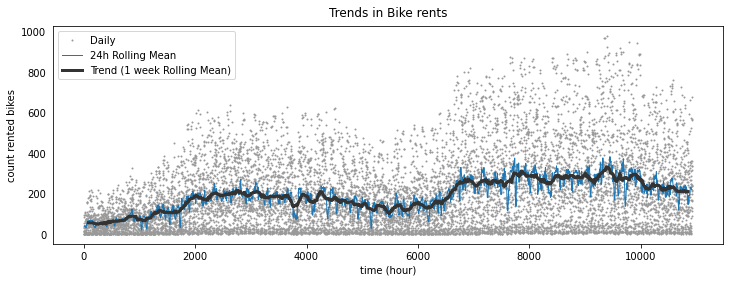

In [234]:
ts_24 = pd.Series(ts.values).rolling(24, center=True).mean()
ts_168 = pd.Series(ts.values).rolling(168, center=True).mean()

## plot :
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ts.values, marker='.', markersize=2, color='0.6',linestyle='None', label='Daily')
ax.plot(ts_24, linewidth=1, label='24h Rolling Mean')
ax.plot(ts_168, color='0.2', linewidth=3, label='Trend (1 week Rolling Mean)')

ax.legend()
ax.set_xlabel('time (hour)')
ax.set_ylabel('count rented bikes')
ax.set_title('Trends in Bike rents')

I know there are missing days, so, to extend to a larger scale does seem inaccurate. Let's compute the trend with other ways (resampling for example) : 

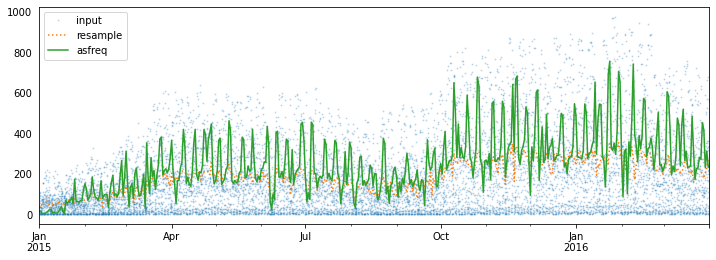

In [263]:
## fake index time : 
false_timeline = pd.date_range("2015-01-01", periods=ts2.shape[0], freq="H")
ts2 = pd.Series(ts.values, index = false_timeline)

## compute trend and plot it : 
plt.figure(figsize=(12,4))
ts2.plot(alpha=0.2, marker='.', markersize=2,linestyle='None')
ts2.resample("D").mean().plot(style=':')
ts2.asfreq('D').plot(style='-');
plt.legend(['input', 'resample', 'asfreq'])
plt.show()



<a id ="section2.2"></a>
[back to menu](#menu)

## 2.B Splitting in 3 classes :

As revealed before, there are three modes in this data, with two distinct comportments : week-end and working days. Holiday seem to be at the middle of the 2 firsts. 

I got the idea, but as it is also give as at the bottom of [this article](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html), let's do it ! 

<a id ="section1.2"></a>
[back to menu](#menu)

## 1.B. Categorical data :
Let's first focus on the categorical data : 

In [33]:
df_cat = train.loc[:,["season","holiday","workingday", "weather"]]
dict_cat = {"season" : {1:"spring", 2 : "summer", 3 : "fall", 4 : "winter" },
            "weather" : {1: "w_very_good", 2: "w_good", 3: "w_bad", 4: "w_very_bad"}
            }

df_dum = df_cat.copy()
for k in dict_cat.keys() :
    corresp = dict_cat[k]
    cat = df_cat.loc[:,k].replace(corresp)
    df_cat.loc[:,k] = cat
    dummies = pd.get_dummies(cat)
    df_dum = pd.concat((df_dum, dummies), axis=1)

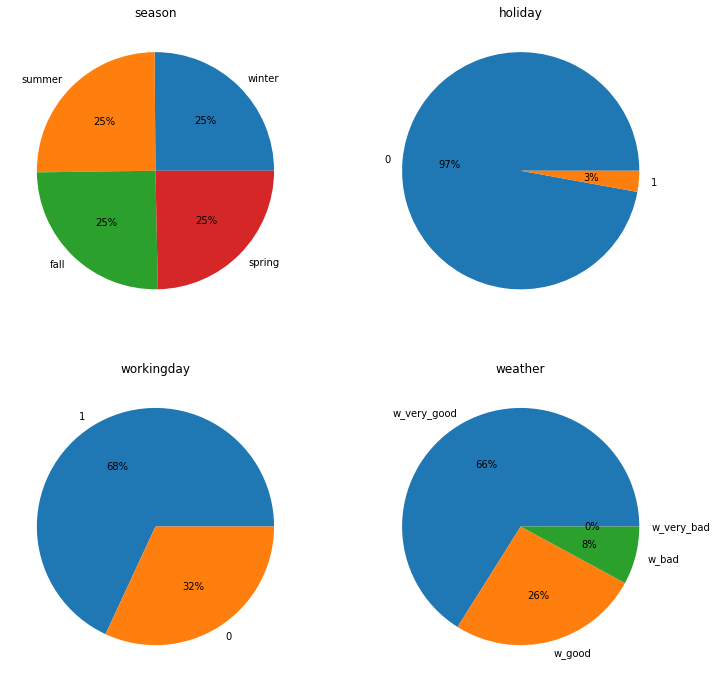

In [52]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('tab10')[0:5]
plot_iter = 1
for k in df_cat.columns : 
    plt.subplot(2,2,plot_iter)
    tmp = df_cat.loc[:,k].value_counts()
    plt.title(k)
    plt.pie(tmp.values, labels = tmp.index,
            colors = colors, autopct='%.0f%%')
    plot_iter += 1

Let's ponderate the disrtibution with the number of rented bikes (the number to be predicted)